#Title: "Copepod Detection"

###Authors:
* Veit Dausmann
* Nils Borchert

###Sources:
* OpenCampus "Tensorflow Course"
* Coursera "Tensorflow Course"
* www.tensorflow.org
* www.keras.io

###Data
*   Geomar (Veit Dausmann)


# Transfer learning and fine-tuning

In [ ]:
#Source: https://www.tensorflow.org/tutorials/images/transfer_learning

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
#Load GDrive Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [ ]:
#Create Train and validation dataset

In [ ]:
BATCH_SIZE = 32 #64
IMG_SIZE = (160, 160)

IMAGE_FOLDER = '/content/drive/MyDrive/plankton_classifier/labeled_plankton'



train_dataset = tf.keras.utils.image_dataset_from_directory(IMAGE_FOLDER,
                                                            validation_split=0.2,
                                                            shuffle=True,
                                                            subset="training",
                                                            seed=1337,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(IMAGE_FOLDER,
                                                                 validation_split=0.2,
                                                                 shuffle=True,
                                                                 subset="validation",
                                                                 seed=1337,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1845 files belonging to 2 classes.
Using 1476 files for training.
Found 1845 files belonging to 2 classes.
Using 369 files for validation.


## Data preprocessing

### Data download

Show the first nine images and labels from the training set:

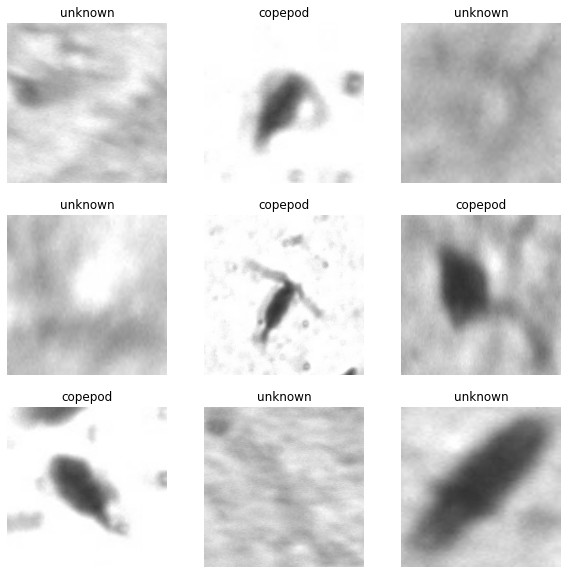

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Create a test dataset.

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 10
Number of test batches: 2


### Configure the dataset for performance

Use buffered prefetching to load images from disk without having I/O become blocking. To learn more about this method see the [data performance](https://www.tensorflow.org/guide/data_performance) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

Rotation and horizontal flipping.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Show rotated images.

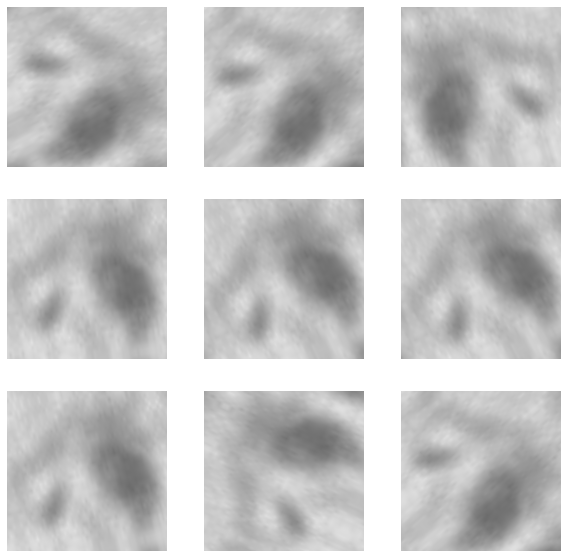

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Rescale pixel values

MobileNetV3 model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet
IMG_SHAPE = IMG_SIZE + (3,)

base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,               
                                               include_top=False,
                                               classes=1000, #2
                                               weights='imagenet')


#tf.keras.applications.MobileNetV3Large
#tf.keras.applications.MobileNetV2

12683000/12683000 [==============================] - 0s 0us/step


This feature extractor converts each `160x160x3` image into a `5x5x1280` block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch)
print(feature_batch.shape)

tf.Tensor(
[[[[160.      160.      160.     ]
   [160.1     160.1     160.1    ]
   [160.5     160.5     160.5    ]
   ...
   [201.      201.      201.     ]
   [200.2     200.2     200.2    ]
   [200.      200.      200.     ]]

  [[159.64375 159.64375 159.64375]
   [159.69626 159.69626 159.69626]
   [159.90625 159.90625 159.90625]
   ...
   [200.64375 200.64375 200.64375]
   [200.03375 200.03375 200.03375]
   [199.88126 199.88126 199.88126]]

  [[158.40625 158.40625 158.40625]
   [158.29375 158.29375 158.29375]
   [157.84375 157.84375 157.84375]
   ...
   [199.40625 199.40625 199.40625]
   [199.45625 199.45625 199.45625]
   [199.46875 199.46875 199.46875]]

  ...

  [[188.8125  188.8125  188.8125 ]
   [188.925   188.925   188.925  ]
   [189.375   189.375   189.375  ]
   ...
   [218.95312 218.95312 218.95312]
   [219.51562 219.51562 219.51562]
   [219.65625 219.65625 219.65625]]

  [[191.28749 191.28749 191.28749]
   [191.23499 191.23499 191.23499]
   [191.025   191.025   191.025  ]
 

## Feature extraction
In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

### Freeze the convolutional base

In [ ]:
base_model.trainable = False

### Important note about BatchNormalization layers

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 160, 160, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 80, 80, 16)   432         ['rescaling_1[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 80, 80, 16)  64          ['Conv[0][0]']    

### Add a classification head

GlobalAveragePooling2D` layer to convert the features to  a single vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 960)


Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a `logit`, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) #0.2
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model

Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` loss with `from_logits=True` since the model provides a linear output.

In [ ]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double) #tf.py_func

In [ ]:
base_learning_rate = 1e-4 #4e-5 #1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics='accuracy')#[tf.keras.metrics.AUC(from_logits=True),'accuracy',auroc])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961   

The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. These are divided between two `tf.Variable` objects, the weights and biases.

In [ ]:
len(model.trainable_variables)

2

### Train the model

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 [==============================] - 28s 117ms/step - loss: 0.6927 - accuracy: 0.4689


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.69
initial accuracy: 0.47


In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[lr_schedule])

Epoch 1/10
47/47 [==============================] - 90s 2s/step - loss: 0.7865 - accuracy: 0.4194 - val_loss: 0.6900 - val_accuracy: 0.4984 - lr: 1.0000e-08
Epoch 2/10
47/47 [==============================] - 4s 79ms/step - loss: 0.7933 - accuracy: 0.4031 - val_loss: 0.7026 - val_accuracy: 0.4852 - lr: 1.1220e-08
Epoch 3/10
47/47 [==============================] - 4s 79ms/step - loss: 0.7944 - accuracy: 0.4228 - val_loss: 0.6869 - val_accuracy: 0.4984 - lr: 1.2589e-08
Epoch 4/10
47/47 [==============================] - 4s 80ms/step - loss: 0.7947 - accuracy: 0.4146 - val_loss: 0.7077 - val_accuracy: 0.4754 - lr: 1.4125e-08
Epoch 5/10
47/47 [==============================] - 4s 80ms/step - loss: 0.7994 - accuracy: 0.4126 - val_loss: 0.6766 - val_accuracy: 0.5016 - lr: 1.5849e-08
Epoch 6/10
47/47 [==============================] - 4s 81ms/step - loss: 0.7810 - accuracy: 0.4214 - val_loss: 0.6953 - val_accuracy: 0.4885 - lr: 1.7783e-08
Epoch 7/10
47/47 [==============================] - 4

In [ ]:
#model.save

### Learning curves

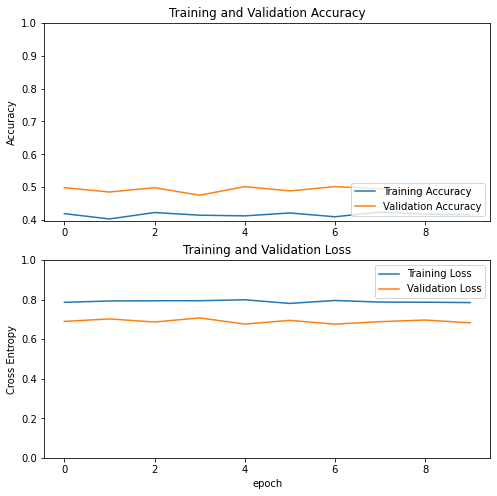

In [ ]:
acc = history.history['accuracy'] #['auc']
val_acc = history.history['val_accuracy']#['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tuning

### Un-freeze the top layers of the model


In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  263


### Compile the model

In [ ]:
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double) #tf.py_func

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              #optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy']) #tf.keras.metrics.AUC(from_logits=True),'accuracy',auroc])
              #metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 5, 5, 960)        2996352   
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 960)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1)                 961   

In [ ]:
len(model.trainable_variables)

94

### Continue training the model

In [ ]:
fine_tune_epochs = 20 #55 #100
total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

In [ ]:
history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)#,
                         #callbacks=[lr_schedule])

Epoch 10/30
47/47 [==============================] - 12s 120ms/step - loss: 0.4288 - accuracy: 0.7839 - val_loss: 0.2206 - val_accuracy: 0.9148
Epoch 11/30
47/47 [==============================] - 5s 93ms/step - loss: 0.2431 - accuracy: 0.8943 - val_loss: 0.1593 - val_accuracy: 0.9148
Epoch 12/30
47/47 [==============================] - 5s 97ms/step - loss: 0.1940 - accuracy: 0.9011 - val_loss: 0.1171 - val_accuracy: 0.9410
Epoch 13/30
47/47 [==============================] - 5s 93ms/step - loss: 0.1796 - accuracy: 0.9133 - val_loss: 0.1133 - val_accuracy: 0.9508
Epoch 14/30
47/47 [==============================] - 5s 94ms/step - loss: 0.1451 - accuracy: 0.9397 - val_loss: 0.0992 - val_accuracy: 0.9574
Epoch 15/30
47/47 [==============================] - 5s 94ms/step - loss: 0.1381 - accuracy: 0.9424 - val_loss: 0.0844 - val_accuracy: 0.9705
Epoch 16/30
47/47 [==============================] - 5s 94ms/step - loss: 0.1323 - accuracy: 0.9451 - val_loss: 0.0835 - val_accuracy: 0.9639
Epoc

(1e-08, 0.001, 0.0, 1.0)

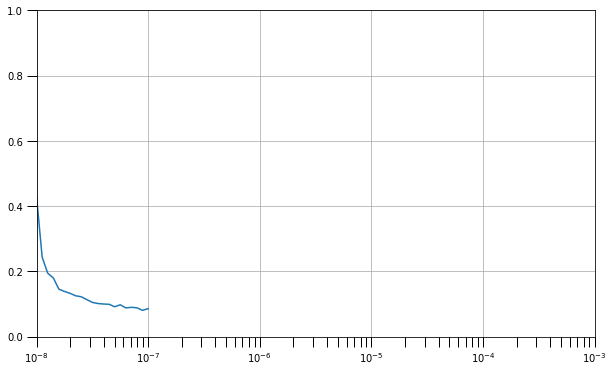

In [ ]:
import matplotlib.pyplot as plt

# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(21) / 20)) #101
#lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_fine.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 1])

In [ ]:
#metrics=[tf.keras.metrics.AUC(from_logits=True)])

acc += history_fine.history['accuracy'] #history['auc'] #['accuracy'] history['auc']
val_acc += history_fine.history['val_accuracy']#['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

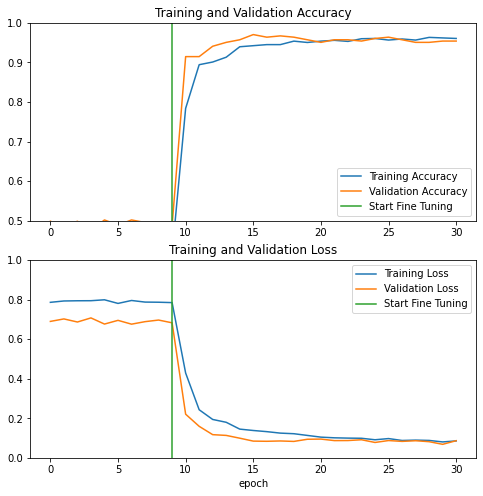

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/plankton/model_0.99.h5')

### Evaluation and prediction

Finally verify the performance of the model on new data using test set.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 0s 57ms/step - loss: 0.0270 - accuracy: 1.0000
Test accuracy : 1.0


Predict if images are plancton or 'unkown'.

Predictions:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0]
Labels:
 [0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 0 0]


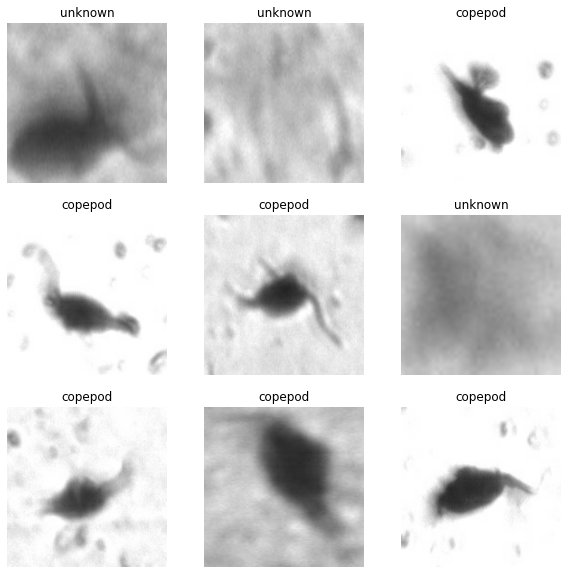

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Test prediction on unkown new images:

In [ ]:
IMG_TESTING = '/content/drive/MyDrive/plankton_classifier/ISIIS_copepod_calanoid'
eigen_dataset = tf.keras.utils.image_dataset_from_directory(IMG_TESTING,
                                                            #validation_split=0.2,
                                                            shuffle=True,
                                                            #subset="validation",
                                                            seed=1337,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 681 files belonging to 1 classes.


In [ ]:

# Retrieve a batch of images from the test set
image_batch, label_batch = eigen_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


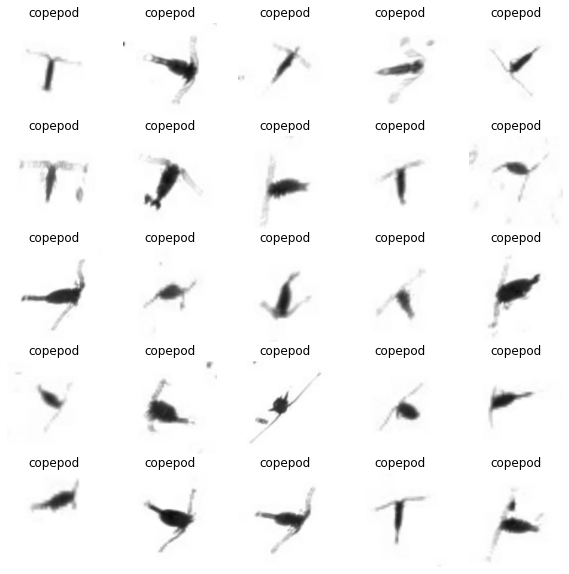

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(25):
  ax = plt.subplot(5, 5, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")